## About

Based on the publication [Introduction to Anomaly Detection](https://www.datascience.com/blog/intro-to-anomaly-detection-learn-data-science-tutorials). Please, note that original source code from article contains couple of flaws, which were corrected in the current notebook. All updates inroduced require Python 3.

### Links

* [Dataset of sunspots](http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt)
* "Convolution Theorem" explained/reviewed
    + [Convolution - wiki](https://en.wikipedia.org/wiki/Convolution)
    + [Introduction to the convolution (sin/cos) - video](https://www.youtube.com/watch?v=IW4Reburjpc)
    + [Visualization of Cross Correlation and Convolution with Matlab - video](https://www.youtube.com/watch?v=Ma0YONjMZLI)
    + [The Convolution Theorem - video](https://www.youtube.com/watch?v=a0IdGLczoAA)
        + It's smoothing (bluring) one function by another
        + Can be used to smooth noise exising in one function (f(t)), by sliding another function (g(t)) over time axis 

### Description of Dataset


#### Data Set Information

The file has 3,143 rows, which contain information about sunspots collected between the years 1749-1984. Sunspots are defined as dark spots on the surface of the sun. The study of sunspots helps scientists understand the sun's properties over a period of time; in particular, its magnetic properties.


#### Attribute Information:

* Months
* SunSpots

### Loading Data

The first step is always a data loading. Before loading, data file was downloaded manually.

In [1]:
%matplotlib inline

from __future__ import division
import matplotlib.pyplot as plt
from itertools import count
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
from pylab import rcParams

#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
#np.set_printoptions(precision=3)
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

# plt
rcParams['figure.figsize'] = 15, 8

In [2]:
# default values for plots
xlim_def = (0, 1000)
ylim_def = (0, 300)

In [3]:
# load txt data
data = loadtxt("data/sunspots.txt", float)

# pandas
df = pd.DataFrame(data, columns=['months', 'sunspots'])
df.head()

,months,sunspots
0,0.0,58.0
1,1.0,62.6
2,2.0,70.0
3,3.0,55.7
4,4.0,85.0


### Visualization

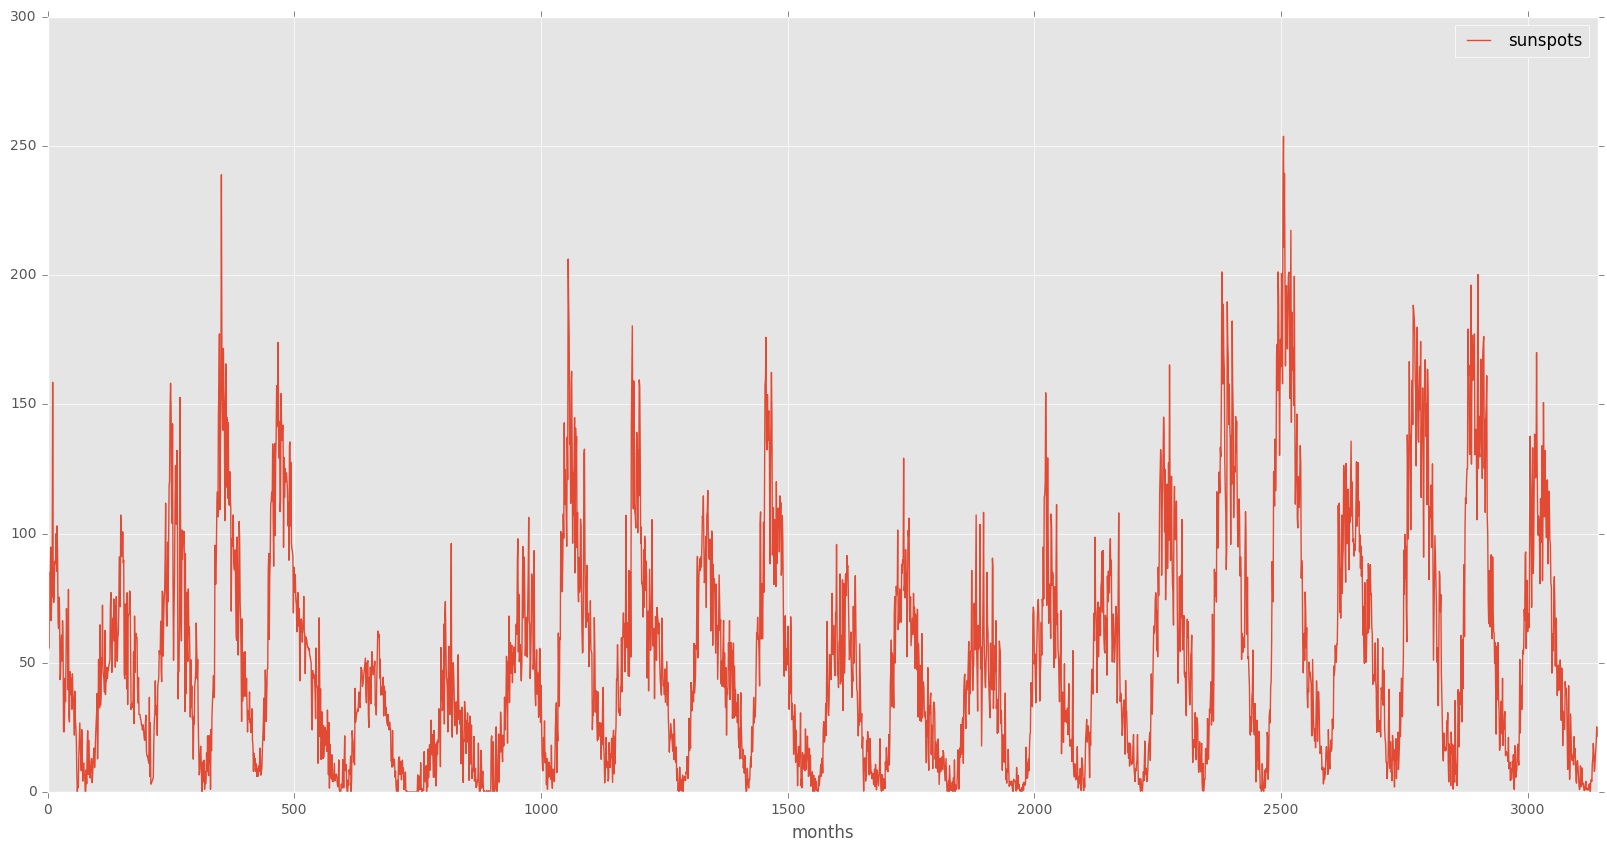

In [4]:
# whole data at once
df.plot(x = df['months'], y = ['sunspots'], figsize = (20,10))

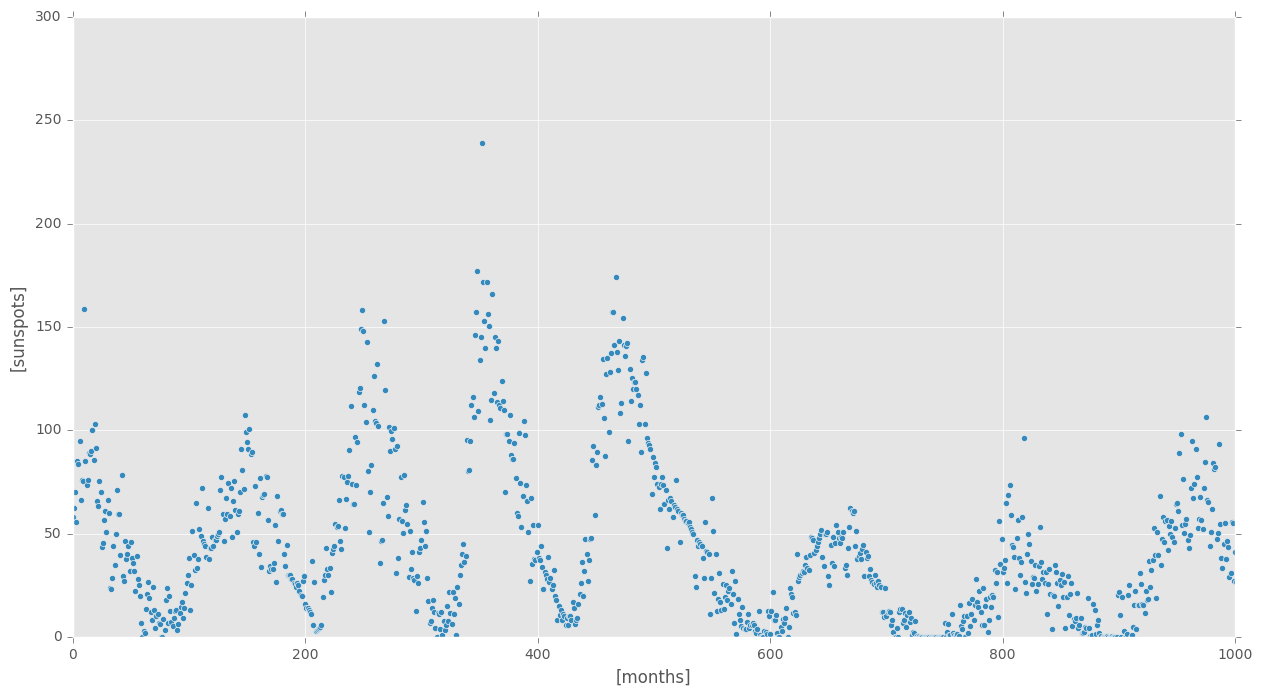

In [5]:
# only part of the data
df.plot.scatter(x = ['months'], y = ['sunspots'], xlim = xlim_def, ylim = ylim_def)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000948BE48>]], dtype=object)

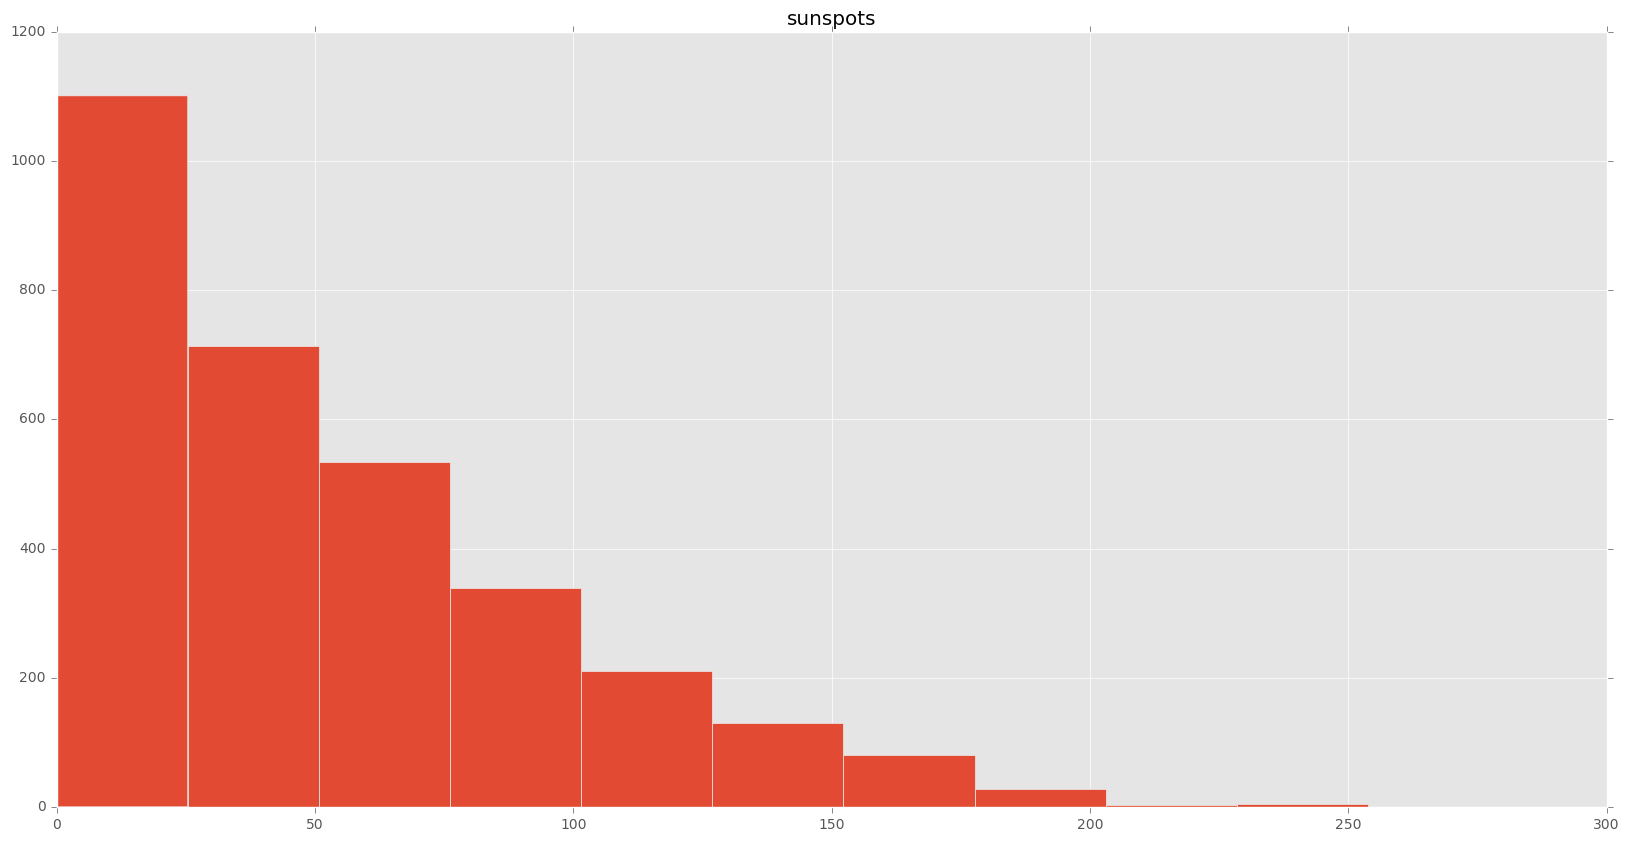

In [6]:
df.hist(column = ['sunspots'], figsize = (20,10))

### Functions

In [7]:
def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

In [8]:
def explain_anomalies(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies

    """
    
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    anomalies_dict = collections.OrderedDict([(index, y_i) for index, y_i, avg_i in zip(count(), y, avg)
                                              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': anomalies_dict}

In [9]:
def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    
    # Calculate the variation in the distribution of the residual
    #testing_std = pd.rolling_std(residual, window_size)
    testing_std = residual.rolling(window=window_size,center=False).std()
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in zip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}

In [10]:
#
# This function is repsonsible for displaying how the function performs on the given dataset.
#

def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", plot_title="", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        plot_title  (str): title fo a plot
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.ylim(0, 300)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)
    plt.title(plot_title)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)
    
#     print (events['anomalies_dict'].keys())
#     print (events['anomalies_dict'].values)
    
    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float, count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

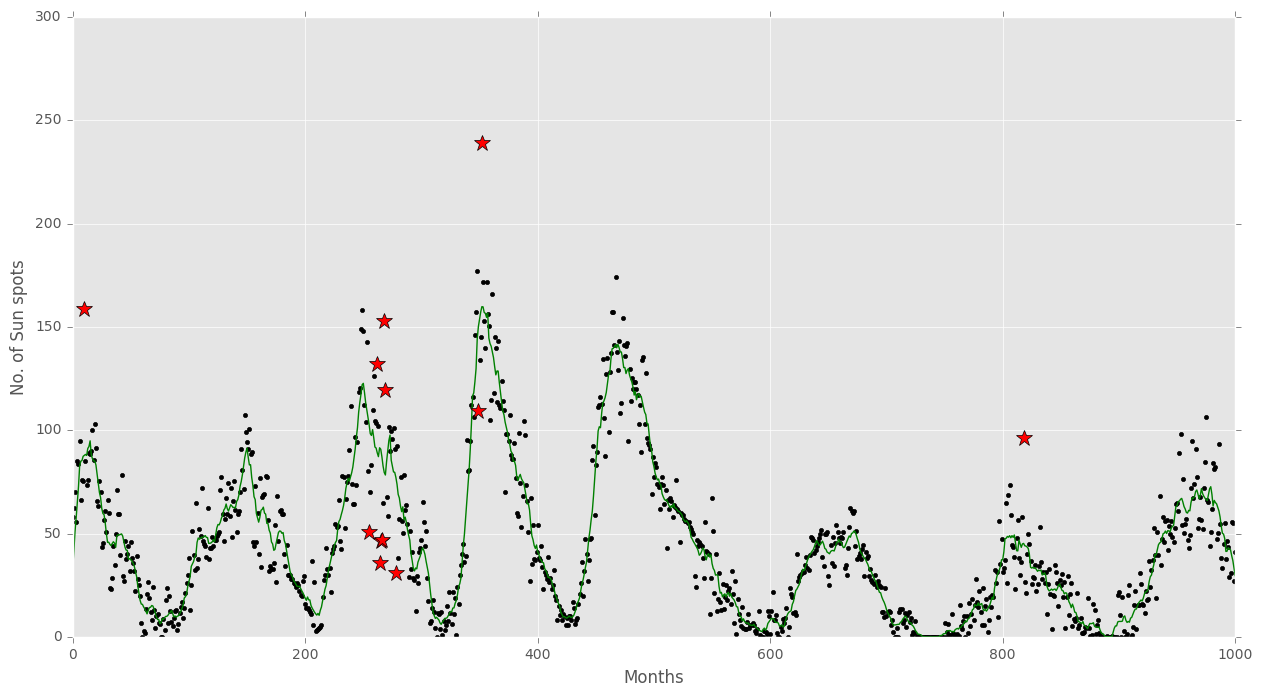

Information about the anomalies model: {'standard_deviation': 11.424, 'anomalies_dict': OrderedDict([(10, 158.59999999999999), (253, 142.5), (255, 51.0), (262, 132.19999999999999), (264, 36.0), (268, 152.69999999999999), (278, 31.100000000000001), (349, 109.3), (352, 238.90000000000001), (361, 165.69999999999999), (818, 96.200000000000003), (986, 93.400000000000006), (1055, 206.30000000000001), (1069, 84.799999999999997), (1172, 107.09999999999999), (1182, 52.200000000000003), (1185, 180.40000000000001), (1464, 88.299999999999997), (1735, 129.19999999999999), (1882, 107.2), (1890, 103.59999999999999), (1897, 108.2), (2023, 154.5), (2025, 72.200000000000003), (2027, 129.30000000000001), (2171, 108.0), (2274, 165.30000000000001), (2380, 201.30000000000001), (2390, 94.799999999999997), (2391, 189.69999999999999), (2503, 158.0), (2518, 152.30000000000001), (2520, 217.40000000000001), (2521, 143.09999999999999), (2527, 199.59999999999999), (2755, 58.100000000000001), (2756, 138.199999999999

In [11]:
x = df['months']
Y = df['sunspots']

# plot the results
plot_results(x, y=Y, window_size=10, text_xlabel="Months", sigma_value=3,
             text_ylabel="No. of Sun spots")
events = explain_anomalies(Y, window_size=5, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model: {0}".format(events))

### Random Data and Anomaly Detection

In [12]:
#
# Convenience function to add noise
#

def noise(yval):
    """ Helper function to generate random points """
    
    np.random.seed(0)
    return 0.2 * np.asarray(yval) * np.random.normal(size=len(yval))

In [13]:
#
# Generate a random dataset
#

def generate_random_dataset(size_of_array=1000, random_state=0):
    """ Helps in generating a random dataset which has a normal distribution
    Args:
    -----
        size_of_array (int): number of data points
        random_state (int): to initialize a random state

    Returns:
    --------
        a list of data points for dependent variable, pandas.Series of independent variable
    """
    
    np.random.seed(random_state)
    y = np.random.normal(0, 0.5, size_of_array)
    x = range(0, size_of_array)
    #y_new = [y_i + index**((size_of_array - index)/size_of_array) + noise(index) for index, y_i in zip(count(), y)]
    y_new = [y_i + index**((size_of_array - index)/size_of_array) for index, y_i in zip(count(), y)]
    y_new = y_new + noise(y_new)
    return x, pd.Series(y_new)

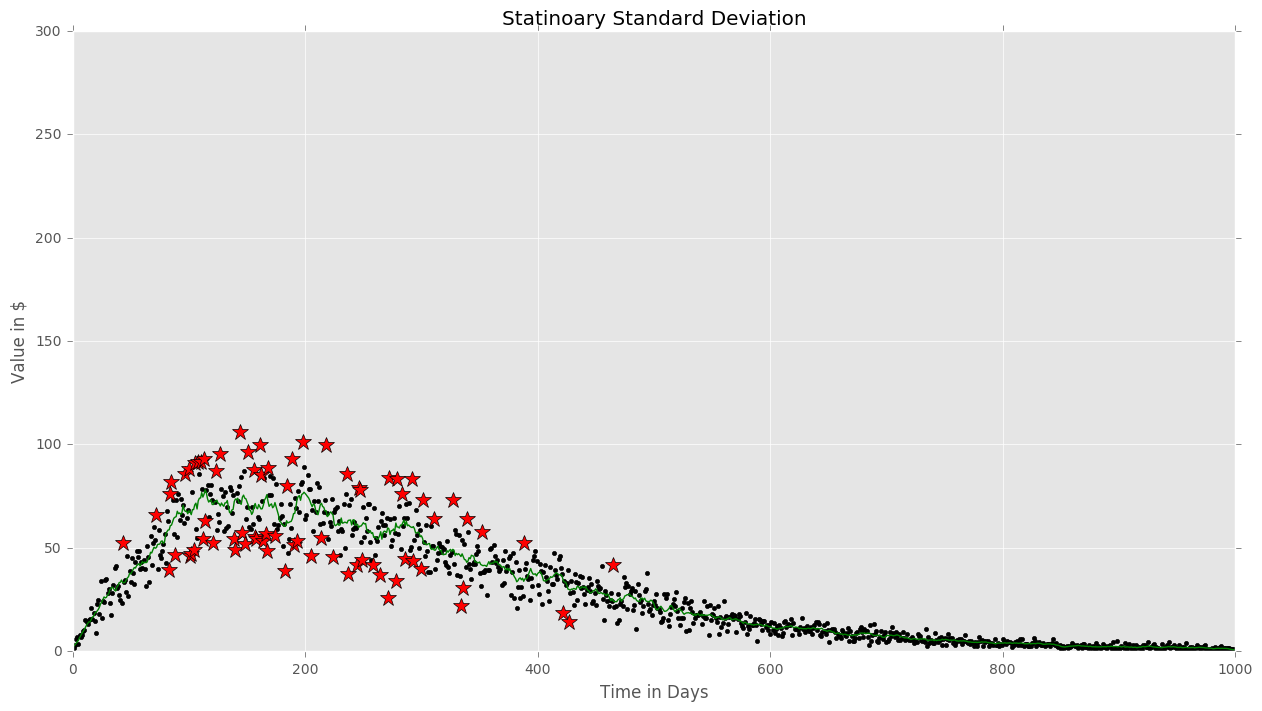

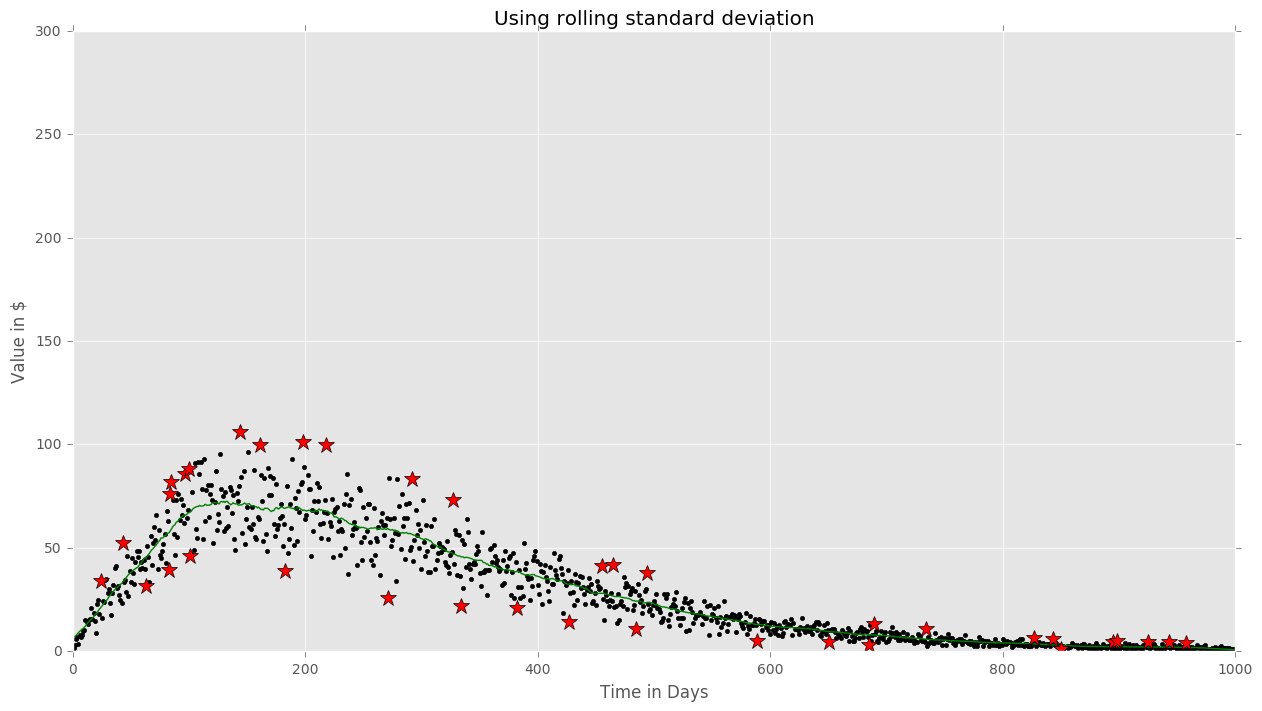

In [14]:
# Using randomly generated data

# generating random set
x1, y1 = generate_random_dataset()

# Using stationary standard deviation over a continuous sample replicating
plot_results(x1, y1, window_size=12, sigma_value=2, 
             text_xlabel="Time in Days", text_ylabel="Value in $", plot_title="Statinoary Standard Deviation")

# using rolling standard deviation for
x1, y1 = generate_random_dataset()
plot_results(x1, y1, window_size=50, sigma_value=2, 
             text_xlabel="Time in Days", text_ylabel="Value in $", plot_title="Using rolling standard deviation", 
             applying_rolling_std=True)